In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.feature_selection import mutual_info_regression, GenericUnivariateSelect, SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoCV

In [37]:
clv_data = pd.read_csv("datasets/clean_clv.csv")

clv_data.head()

,State,Customer Lifetime Value,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,Washington,2763.519279,No,Basic,Bachelor,Employed,F,56274,Suburban,Married,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,Arizona,6979.535903,No,Extended,Bachelor,Unemployed,F,0,Suburban,Single,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,Nevada,12887.431650,No,Premium,Bachelor,Employed,F,48767,Suburban,Married,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,California,7645.861827,No,Basic,Bachelor,Unemployed,M,0,Suburban,Married,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,Washington,2813.692575,No,Basic,Bachelor,Employed,M,43836,Rural,Single,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


#### spliting the data to test and train 30% and 70%

In [48]:
X = clv_data.drop(columns=["Customer Lifetime Value"])
y = clv_data["Customer Lifetime Value"]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=12)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6393, 21), (2741, 21), (6393,), (2741,))

In [49]:
clv_data["Coverage"].unique()

array(['Basic', 'Extended', 'Premium'], dtype=object)

In [50]:
clv_data["Education"].unique()

array(['Bachelor', 'College', 'Master', 'High School or Below', 'Doctor'],
      dtype=object)

## TODO Recording Please expand each item in the Transformer result

#### Encoding categorical data

- One-hot encode nominal data
- Ordinal encoder ordinal data (data with a certain rank)
- Standardize numeric data

#### Unknown values in the test data

Your problem is that the model has encountered a value in the test data that it had not seen in the training data. This is fine. You just need to add the 'handle_unknown' argument to your encoder.

You should fit encoders and scalers to the training data (but not the test data) and then use them to transform both training and test data. Thus, you must plan for the possibility of unexpected values in the test data.

The gender O may be an unknown values in the test data (may not see it in training)

In [65]:
transformer = ColumnTransformer(transformers=[
  ("oe_coverage", OrdinalEncoder(categories=[["Basic", 
                                              "Extended", 
                                              "Premium"]]), ["Coverage"]),
    
  ("oe_education", OrdinalEncoder(categories=[["High School or Below", 
                                               "College", 
                                               "Bachelor", 
                                               "Master", 
                                               "Doctor"]]), ["Education"]),
    
  ("one_hot_enc", OneHotEncoder(sparse=False, handle_unknown = 'ignore', drop="first"), 
       ["State", 
        "Response", 
        "EmploymentStatus", 
        "Gender", 
        "Location Code", 
        "Marital Status", 
        "Policy Type", 
        "Policy", 
        "Renew Offer Type", 
        "Sales Channel", 
        "Vehicle Class", 
        "Vehicle Size"])], 
  remainder=StandardScaler()
)

transformer

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('oe_coverage',
                                 OrdinalEncoder(categories=[['Basic',
                                                             'Extended',
                                                             'Premium']]),
                                 ['Coverage']),
                                ('oe_education',
                                 OrdinalEncoder(categories=[['High School or '
                                                             'Below',
                                                             'College',
                                                             'Bachelor',
                                                             'Master',
                                                             'Doctor']]),
                                 ['Education']),
                                ('one_hot_enc',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['State', 'Response', 'EmploymentStatus',
                                  'Gender', 'Location Code', 'Marital Status',
                                  'Policy Type', 'Policy', 'Renew Offer Type',
                                  'Sales Channel', 'Vehicle Class',
                                  'Vehicle Size'])])

In [66]:
transformed_X_train = pd.DataFrame(transformer.fit_transform(X_train), 
                                   columns=transformer.get_feature_names_out(), 
                                   index=X_train.index)

transformed_X_train.head(10)

,oe_coverage__Coverage,oe_education__Education,one_hot_enc__State_California,one_hot_enc__State_Nevada,one_hot_enc__State_Oregon,one_hot_enc__State_Washington,one_hot_enc__Response_Yes,one_hot_enc__EmploymentStatus_Employed,one_hot_enc__EmploymentStatus_Medical Leave,one_hot_enc__EmploymentStatus_Retired,...,one_hot_enc__Vehicle Class_Two-Door Car,one_hot_enc__Vehicle Size_Medsize,one_hot_enc__Vehicle Size_Small,remainder__Income,remainder__Monthly Premium Auto,remainder__Months Since Last Claim,remainder__Months Since Policy Inception,remainder__Number of Open Complaints,remainder__Number of Policies,remainder__Total Claim Amount
4197,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-1.242577,-0.594670,-1.397247,-0.610096,-0.421730,0.007895,0.328963
306,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-1.242577,0.685001,-1.496691,-0.110189,-0.421730,-0.409242,1.388585
6895,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.678404,-0.445871,-0.601691,0.532548,-0.421730,-0.826379,0.075367
7503,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,-0.091963,-0.594670,-0.701136,1.496655,-0.421730,-0.826379,0.142911
7181,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-1.242577,-0.029234,-0.203913,-1.110003,-0.421730,-0.826379,0.037155
6684,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-1.242577,-0.951787,0.193865,-1.681326,0.678727,1.676443,-0.479763
8629,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,-0.229513,-0.356591,1.088865,-0.788635,-0.421730,-0.826379,-1.050255
7804,2.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.892910,0.327884,-0.900025,-0.538681,-0.421730,0.007895,-0.833410
4235,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.476683,-0.743468,0.492198,-0.681512,-0.421730,-0.409242,-0.626999
1766,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-1.242577,-0.743468,-1.496691,-0.003066,0.678727,0.842169,0.203902


In [67]:
transformed_X_train.columns

Index(['oe_coverage__Coverage', 'oe_education__Education',
       'one_hot_enc__State_California', 'one_hot_enc__State_Nevada',
       'one_hot_enc__State_Oregon', 'one_hot_enc__State_Washington',
       'one_hot_enc__Response_Yes', 'one_hot_enc__EmploymentStatus_Employed',
       'one_hot_enc__EmploymentStatus_Medical Leave',
       'one_hot_enc__EmploymentStatus_Retired',
       'one_hot_enc__EmploymentStatus_Unemployed', 'one_hot_enc__Gender_M',
       'one_hot_enc__Gender_O', 'one_hot_enc__Location Code_Suburban',
       'one_hot_enc__Location Code_Urban',
       'one_hot_enc__Marital Status_Married',
       'one_hot_enc__Marital Status_Single',
       'one_hot_enc__Policy Type_Personal Auto',
       'one_hot_enc__Policy Type_Special Auto',
       'one_hot_enc__Policy_Corporate L2', 'one_hot_enc__Policy_Corporate L3',
       'one_hot_enc__Policy_Personal L1', 'one_hot_enc__Policy_Personal L2',
       'one_hot_enc__Policy_Personal L3', 'one_hot_enc__Policy_Special L1',
       'one_h

#### getting train and test score without any feature selection. Rsquare is low (very poor performance with linear regression)

In [68]:
model = LinearRegression()

pipeline = Pipeline(steps=[("transformer", transformer), ("model", model)])

pipeline.fit(X_train, y_train)
print("Training Score: ", pipeline.score(X_train, y_train))

y_pred = pipeline.predict(X_test)

print("Testing Score: ", r2_score(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, squared=False))

Training Score:  0.1733134227682257
Testing Score:  0.15187282712178485
MAE:  3984.2572536846546
RMSE:  6450.48333937945


#### predict and actual dataframe

In [69]:
predict_vs_actual = pd.DataFrame({"Predicted": pipeline.predict(X_test), "Actual": y_test})

predict_vs_actual.head(10)

,Predicted,Actual
5260,11980.643096,9259.715798
3995,7291.106439,3808.122147
7495,10179.469338,4633.550875
5610,7981.940306,3549.016697
2061,6671.092293,5689.644114
6844,5661.406936,5502.726803
7062,7549.763636,3694.148760
3975,6197.679850,4995.211519
5228,4778.524630,2242.226055
1104,4637.419190,4880.946440


#### ploting predicted vs actual and limiting to just 50 entries

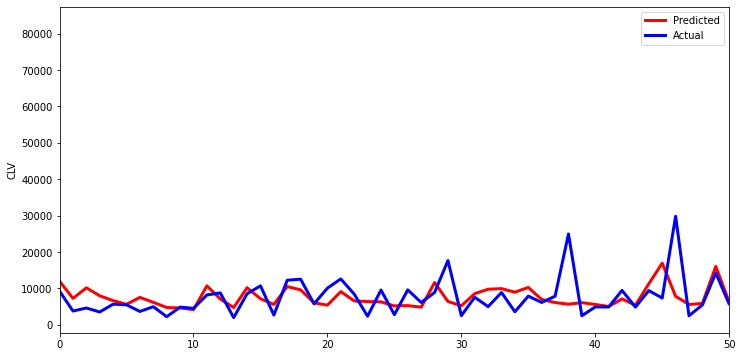

In [70]:
plt.figure(figsize = [12, 6])

plt.plot(pipeline.predict(X_test), label="Predicted", linewidth=3, color="red")
plt.plot(y_test.values, label="Actual", linewidth=3, color="blue")

plt.xlim([0, 50])
plt.ylabel("CLV")
plt.legend()
plt.show()

#### Cross-Validation method and  plotting learning curve.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

Determines cross-validated training and test scores for different training set sizes.

A cross-validation generator splits the whole dataset k times in training and test data. Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the test set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

Note that we use the complete data available since cross-validation will automatically split into training and test sets

In [ ]:
model = LinearRegression()

pipeline = Pipeline(steps=[("transformer", transformer), ("model", model)])

train_sizes, train_scores, test_scores = learning_curve(pipeline.fit(X, y), X, y, cv=5)

### Training sizes, train scores, test scores

- We do 5-fold cross validation and have 5 training sizes
- For each training size we get a training score for each of the 5 data subsets (train folds 1-2-3-4 test fold 5, train folds 1-2-3-5 test fold 4 etc)
- For each training size we get a test score for each of the 5 data subsets (train folds 1-2-3-4 test fold 5, train folds 1-2-3-5 test fold 4 etc)

In [71]:
print("train_size: ", train_sizes)
print("train_scores: ", train_scores)
print("test_scores: ", test_scores)

/Users/jananiravi/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jananiravi/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jananiravi/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jananiravi/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jananiravi/opt/anaconda3/

train_size:  [ 730 2374 4018 5662 7307]
train_scores:  [[0.26387254 0.22594499 0.22594499 0.22594499 0.22594499]
 [0.19922884 0.18147487 0.18406021 0.18406021 0.18406021]
 [0.19923939 0.18798914 0.17931047 0.17643195 0.17643195]
 [0.1849249  0.1791294  0.16964686 0.18064983 0.18359549]
 [0.17488806 0.17021878 0.16311832 0.1700192  0.17654313]]
test_scores:  [[0.09002225 0.10590176 0.11043578 0.11409705 0.05764474]
 [0.13168059 0.15893412 0.15493147 0.13271662 0.11201026]
 [0.12704449 0.15681869 0.17097056 0.14425414 0.12368015]
 [0.1310815  0.15234581 0.18339809 0.15418044 0.1282012 ]
 [0.13364819 0.15562873 0.18412786 0.15944619 0.13248441]]


#### getting mean and std deviation of the train and test scores

Mean and standard deviation for each training size

In [75]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

print("train_mean: ", train_mean)
print("train_std: ", train_std)
print("test_mean: ", test_mean)
print("test_std: ", test_std)

train_mean:  [0.2335305  0.18657687 0.18388058 0.1795893  0.1709575 ]
train_std:  [0.01517102 0.00640474 0.00877067 0.00537971 0.00468033]
test_mean:  [0.09562032 0.13805461 0.14455361 0.14984141 0.15306708]
test_std:  [0.02068854 0.017136   0.01783619 0.0198564  0.01904083]


#### seems like the training score is decreasing as we increase the training size where as the test score is improving marginally

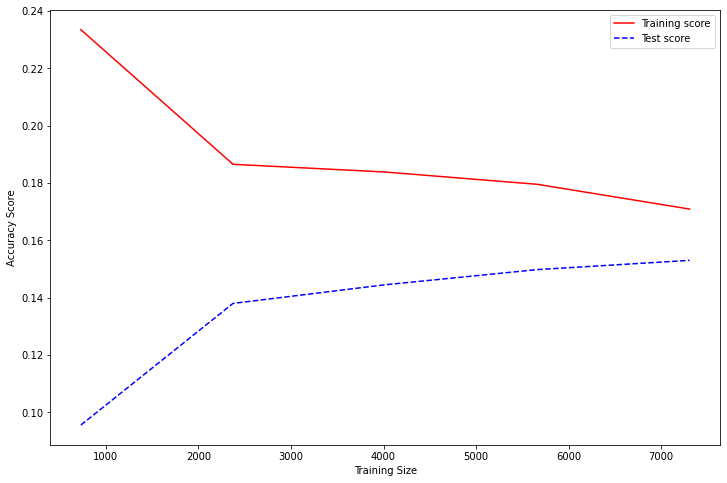

In [76]:
plt.figure(figsize = [12, 8])

plt.plot(train_sizes, train_mean, color="red", label="Training score")
plt.plot(train_sizes, test_mean, "--", color="blue", label="Test score")

plt.xlabel("Training Size")
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()

* https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression
#### here we are selecting the best 10 features(default)

In [77]:
feature_selection = SelectKBest(score_func=f_regression, k=10)

model = LinearRegression()

pipeline = Pipeline(steps=[("transformer", transformer), 
                           ("feature_selection", feature_selection), ("model", model)])

In [78]:
pipeline.fit(X_train, y_train)
print("Training Score: ", pipeline.score(X_train, y_train))

y_pred = pipeline.predict(X_test)
print("Testing Score: ", r2_score(y_test, y_pred))

Training Score:  0.16280934399509128
Testing Score:  0.15783644214159853


Alternative way of doing the above feature selection

In [79]:
feature_selection = GenericUnivariateSelect(f_regression, mode="k_best", param=10)

pipeline = Pipeline(steps=[("transformer", transformer), 
                           ("feature_selection", feature_selection), 
                           ("model", model)])

pipeline.fit(X_train, y_train)
print("Training Score: ", pipeline.score(X_train, y_train))

y_pred = pipeline.predict(X_test)
print("Testing Score: ", r2_score(y_test, y_pred))

Training Score:  0.16280934399509128
Testing Score:  0.15783644214159853


#### here we are creating a loop and incrementing the K  by one and checking performance with no. of features(top-k)

- Note that using just one feature which is the most statistically important gives us results better than using all features in the regression
- Overall the model does not improve as you add features

In [86]:
mse_scr, mae_scr, r_square_scr = ([] for lst in range (0, 3))

for i in range(1, len(transformed_X_train.columns) + 1, 1):
    feature_selection = SelectKBest(score_func=f_regression, k=i)

    pipeline = Pipeline(steps=[("transformer", transformer), 
                               ("feature_selection", feature_selection), 
                               ("model", LinearRegression())])
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    
    print("MSE (k={}): {}".format(i, mean_squared_error(y_test, y_pred, squared=False)))
    mse_scr.append(mean_squared_error(y_test, y_pred, squared=False))
    
    print("MAE (k={}): {}".format(i, mean_absolute_error(y_test, y_pred)))
    mae_scr.append(mean_absolute_error(y_test, y_pred))
    
    print("R-square score (k={}): {}".format(i, r2_score(y_test, y_pred)), end='\n{}\n'.format(50*'-'))
    r_square_scr.append(r2_score(y_test, y_pred))
    

MSE (k=1): 6431.040022944551
MAE (k=1): 3947.2681161242467
R-square score (k=1): 0.15697804206431798
--------------------------------------------------
MSE (k=2): 6427.2238246961515
MAE (k=2): 3944.702984344797
R-square score (k=2): 0.15797824868031418
--------------------------------------------------
MSE (k=3): 6427.082247194929
MAE (k=3): 3944.725326592764
R-square score (k=3): 0.15801534401907869
--------------------------------------------------
MSE (k=4): 6427.046138886177
MAE (k=4): 3941.169733236661
R-square score (k=4): 0.15802480478380831
--------------------------------------------------
MSE (k=5): 6429.113631540594
MAE (k=5): 3943.5337758819037
R-square score (k=5): 0.15748301389392716
--------------------------------------------------
MSE (k=6): 6430.517408172404
MAE (k=6): 3948.2314626693137
R-square score (k=6): 0.15711505188709096
--------------------------------------------------
MSE (k=7): 6432.386292561228
MAE (k=7): 3950.755705797143
R-square score (k=7): 0.15662504

Scores dataframe is made and Regression metrics are plotted with no. of features(top-k).MAE and MSE values are almost constant and Rsquare is marginally increasing which is still very low.

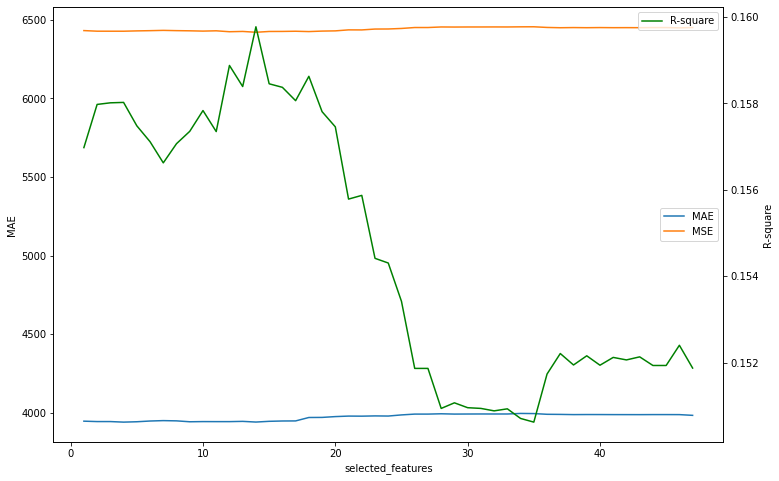

In [87]:
scores = pd.DataFrame({"selected_features": range(1, len(transformed_X_train.columns) + 1), 
                       "MAE": mae_scr,
                       "MSE": mse_scr,
                       "R-square": r_square_scr})


f, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()

sns.lineplot(x='selected_features', y='MAE', label="MAE", data=scores, ax=ax1)
sns.lineplot(x='selected_features', y='MSE', label="MSE", data=scores, ax=ax1)
sns.lineplot(x='selected_features', y="R-square", label="R-square", 
             color="green", data=scores, ax=ax2)

plt.show()

As Linear Regression is not giving good performance, We are using Random Forest and checking the Performances with no. of features(top-k)

In [88]:
mse_scr, mae_scr, r_square_scr = ([] for lst in range (0, 3))

for i in range(1, len(transformed_X_train.columns) + 1, 1):
    feature_selection = SelectKBest(score_func=mutual_info_regression, k=i)

    pipeline = Pipeline(steps=[("transformer", transformer), 
                               ("feature_selection", feature_selection), 
                               ("model", RandomForestRegressor())])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    
    print("MSE (k={}): {}".format(i, mean_squared_error(y_test, y_pred, squared=False)))
    mse_scr.append(mean_squared_error(y_test, y_pred, squared=False))
    
    print("MAE (k={}): {}".format(i, mean_absolute_error(y_test, y_pred)))
    mae_scr.append(mean_absolute_error(y_test, y_pred))
    
    print("R-square score (k={}): {}".format(i, r2_score(y_test, y_pred)), end='\n{}\n'.format(50*'-'))
    r_square_scr.append(r2_score(y_test, y_pred))

MSE (k=1): 6620.225151402482
MAE (k=1): 4005.704481173253
R-square score (k=1): 0.10664930066542633
--------------------------------------------------
MSE (k=2): 6665.523229109647
MAE (k=2): 4072.4706793284986
R-square score (k=2): 0.09438219072692888
--------------------------------------------------
MSE (k=3): 6342.170049377495
MAE (k=3): 3852.2472638776762
R-square score (k=3): 0.1801163484628403
--------------------------------------------------
MSE (k=4): 3870.836070870138
MAE (k=4): 1463.238535605132
R-square score (k=4): 0.6945880535901852
--------------------------------------------------
MSE (k=5): 3865.503502959785
MAE (k=5): 1508.4885392696772
R-square score (k=5): 0.6954289613903875
--------------------------------------------------
MSE (k=6): 3811.116316586227
MAE (k=6): 1494.957226869691
R-square score (k=6): 0.7039392264507711
--------------------------------------------------
MSE (k=7): 3784.489948742696
MAE (k=7): 1480.748211427676
R-square score (k=7): 0.7080616331336

At around k=5,Performance peaked(R-square became 0.67 around) for RF model and after that it is stable

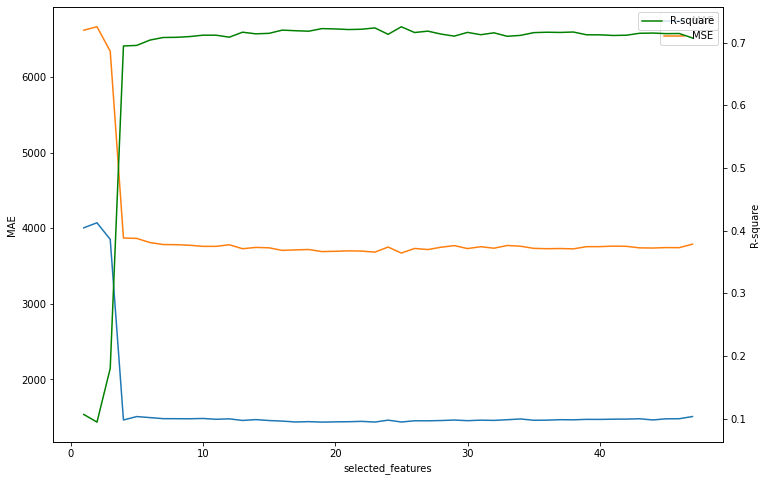

In [89]:
scores = pd.DataFrame({"selected_features": range(1, len(transformed_X_train.columns) + 1), 
                       "MAE": mae_scr,
                       "MSE": mse_scr,
                       "R-square": r_square_scr})


f, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()

sns.lineplot(x='selected_features', y='MAE', label="MAE", data=scores, ax=ax1)
sns.lineplot(x='selected_features', y='MSE', label="MSE", data=scores, ax=ax1)
sns.lineplot(x='selected_features', y="R-square", label="R-square", 
             color="green", data=scores, ax=ax2)

plt.show()

Taking k=5, We are checking performance

In [91]:
feature_selection = SelectKBest(score_func=mutual_info_regression, k=5)
pipeline = Pipeline(steps=[("transformer", transformer), 
                           ("feature_selection", feature_selection), 
                           ("model", RandomForestRegressor())])

pipeline.fit(X_train, y_train)
print("Training Score: ", pipeline.score(X_train, y_train))

y_pred = pipeline.predict(X_test)
print("Testing Score: ", r2_score(y_test, y_pred))

Training Score:  0.9531444371269662
Testing Score:  0.7027765942183186


Selected features are obtained

In [92]:
mask = pipeline["feature_selection"].get_support()

mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False,  True, False,
        True,  True])

In [93]:
feature_names = transformer.get_feature_names_out()

selected_features = []
for selected, feature in zip(mask, feature_names):
    if selected:
        selected_features.append(feature)
        
selected_features     

['remainder__Income',
 'remainder__Monthly Premium Auto',
 'remainder__Months Since Policy Inception',
 'remainder__Number of Policies',
 'remainder__Total Claim Amount']

In [94]:
pipeline["feature_selection"].scores_

array([0.31116594, 0.15801778, 0.        , 0.00341766, 0.        ,
       0.        , 0.28312293, 0.11312415, 0.02242667, 0.08065341,
       0.07466229, 0.06633746, 0.        , 0.07078169, 0.04186623,
       0.08143671, 0.07938239, 0.00271471, 0.00316708, 0.        ,
       0.00410852, 0.        , 0.01099596, 0.        , 0.        ,
       0.00447672, 0.        , 0.09811478, 0.03355402, 0.01454485,
       0.06203504, 0.05037736, 0.04105065, 0.01587686, 0.02815449,
       0.15325907, 0.04593638, 0.07334531, 0.06553549, 0.03740307,
       0.81616162, 1.63119026, 0.42258808, 0.5446532 , 0.08687012,
       0.80193478, 0.99978639])

In [95]:
pipeline["feature_selection"].scores_[mask]

array([0.81616162, 1.63119026, 0.5446532 , 0.80193478, 0.99978639])

#### scores of all features among all these features the best 5 are taken 

In [96]:
selected_feature_df = pd.DataFrame({"Feature": selected_features  , 
                                    "Scores": pipeline["feature_selection"].scores_[mask]})

selected_feature_df.sort_values(by="Scores", ascending=False, ignore_index=True)

,Feature,Scores
0,remainder__Monthly Premium Auto,1.631190
1,remainder__Total Claim Amount,0.999786
2,remainder__Income,0.816162
3,remainder__Number of Policies,0.801935
4,remainder__Months Since Policy Inception,0.544653


## Recursive Feature Elimination

#### this is computional intensive recursive feature elemination technique (RFE / RFECV)
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE
* https://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination
* here we are selecting n_features_to_select = 10
RFE method was very slow. So for performances with no. of features is not showing as it was taking too long.Even RFECV was too slow

In [97]:
model = RandomForestRegressor()

feature_selection = RFE(estimator=model, n_features_to_select=10, step=1)

pipeline = Pipeline(steps=[("transformer", transformer),
                           ("feature_selection", feature_selection), 
                           ("model", model)])

In [98]:
pipeline.fit(X_train, y_train)
print("Training Score: ", pipeline.score(X_train, y_train))

y_pred = pipeline.predict(X_test)
print("Testing Score: ", r2_score(y_test, y_pred))

Training Score:  0.9544818185466147
Testing Score:  0.7111497960588022


In [99]:
mask = pipeline["feature_selection"].get_support()

mask

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True])

In [100]:
feature_names = transformer.get_feature_names_out()

selected_features = []
for selected, feature in zip(mask, feature_names):
    if selected:
        selected_features.append(feature)
        
selected_features

['oe_coverage__Coverage',
 'oe_education__Education',
 'one_hot_enc__Policy Type_Personal Auto',
 'remainder__Income',
 'remainder__Monthly Premium Auto',
 'remainder__Months Since Last Claim',
 'remainder__Months Since Policy Inception',
 'remainder__Number of Open Complaints',
 'remainder__Number of Policies',
 'remainder__Total Claim Amount']

#### scores of all features among all these features the best 10 are taken 

In [101]:
selected_feature_df = pd.DataFrame({"Feature": selected_features  , 
                                    "Scores": pipeline["feature_selection"].ranking_[mask]})

selected_feature_df.sort_values(by="Scores", ascending=False, ignore_index=True)

,Feature,Scores
0,oe_coverage__Coverage,1
1,oe_education__Education,1
2,one_hot_enc__Policy Type_Personal Auto,1
3,remainder__Income,1
4,remainder__Monthly Premium Auto,1
5,remainder__Months Since Last Claim,1
6,remainder__Months Since Policy Inception,1
7,remainder__Number of Open Complaints,1
8,remainder__Number of Policies,1
9,remainder__Total Claim Amount,1


## SelectFromModel

#### select from model feature selection
* SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute (such as coef_, feature_importances_)
* https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

Feature selection is defined and both Training and test data are transformed using Transformer defined earlier.

In [104]:
feature_selection = SelectFromModel(LassoCV())

X_train_sfm = transformer.fit_transform(X_train)
X_test_sfm = transformer.transform(X_test)

Feature selection is applied.Note that 27 features are selected

In [105]:
X_train_new = feature_selection.fit_transform(X_train_sfm ,y_train)
X_test_new = feature_selection.transform(X_test_sfm)

X_train_new.shape, X_test_new.shape

((6393, 27), (2741, 27))

#### Feature selection using one model, actual training can use another model

Model is defined and fit. Predictions are obtained and performance scores are found out

In [110]:
model = RandomForestRegressor()

model.fit(X_train_new, y_train)
print("Training Score: ", model.score(X_train_new , y_train))

y_pred = model.predict(X_test_new)
print("Testing Score: ", r2_score(y_test, y_pred))

Training Score:  0.9554018574346125
Testing Score:  0.7136644099636613


Now selected features are shown

In [111]:
mask = feature_selection.get_support()

mask

array([ True,  True, False,  True, False,  True,  True,  True, False,
       False,  True, False, False,  True,  True, False,  True, False,
        True,  True,  True, False, False,  True, False, False, False,
        True,  True,  True, False, False, False, False, False,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True])

In [112]:
selected_features = []

for selected, feature in zip(mask,feature_names):
    if selected:
        selected_features.append(feature)
        
selected_features       

['oe_coverage__Coverage',
 'oe_education__Education',
 'one_hot_enc__State_Nevada',
 'one_hot_enc__State_Washington',
 'one_hot_enc__Response_Yes',
 'one_hot_enc__EmploymentStatus_Employed',
 'one_hot_enc__EmploymentStatus_Unemployed',
 'one_hot_enc__Location Code_Suburban',
 'one_hot_enc__Location Code_Urban',
 'one_hot_enc__Marital Status_Single',
 'one_hot_enc__Policy Type_Special Auto',
 'one_hot_enc__Policy_Corporate L2',
 'one_hot_enc__Policy_Corporate L3',
 'one_hot_enc__Policy_Personal L3',
 'one_hot_enc__Renew Offer Type_Offer2',
 'one_hot_enc__Renew Offer Type_Offer3',
 'one_hot_enc__Renew Offer Type_Offer4',
 'one_hot_enc__Vehicle Class_SUV',
 'one_hot_enc__Vehicle Class_Two-Door Car',
 'one_hot_enc__Vehicle Size_Small',
 'remainder__Income',
 'remainder__Monthly Premium Auto',
 'remainder__Months Since Last Claim',
 'remainder__Months Since Policy Inception',
 'remainder__Number of Open Complaints',
 'remainder__Number of Policies',
 'remainder__Total Claim Amount']

In [363]:
selected_features_df = pd.DataFrame(X_train_new, columns=selected_features)

selected_features_df

,oe_education__Education,one_hot_enc__EmploymentStatus_Employed,one_hot_enc__EmploymentStatus_Unemployed,one_hot_enc__Marital Status_Single,one_hot_enc__Renew Offer Type_Offer2,one_hot_enc__Renew Offer Type_Offer4,one_hot_enc__Sales Channel_Call Center,remainder__Income,remainder__Monthly Premium Auto,remainder__Months Since Last Claim,remainder__Number of Open Complaints,remainder__Number of Policies,remainder__Total Claim Amount
0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.240719,0.055457,-0.212614,-0.424950,0.858748,0.076555
1,1.0,0.0,1.0,1.0,0.0,1.0,0.0,-1.240719,1.055636,-1.298982,-0.424950,-0.821942,1.714232
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.114696,0.261376,-0.015093,2.828587,-0.401770,0.192938
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.476920,0.937968,-0.706418,3.913099,-0.821942,1.227248
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.240719,-0.238714,-1.101460,-0.424950,-0.401770,1.534928
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6388,0.0,0.0,1.0,1.0,1.0,0.0,1.0,-1.240719,-0.885889,-1.002700,-0.424950,-0.821942,0.068242
6389,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.737597,-0.591718,-1.002700,0.659563,0.018403,-1.047046
6390,2.0,0.0,1.0,1.0,1.0,0.0,0.0,-1.240719,1.408641,0.972514,-0.424950,0.018403,2.013503
6391,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.699748,0.996802,1.663838,1.744075,1.278920,-0.713479


Alternatively, We can easily obtain the predictions using Pipeline 

In [114]:
feature_selection = SelectFromModel(LassoCV())
model = RandomForestRegressor()

pipeline = Pipeline(steps=[("transformer", transformer), 
                           ("feature_selection", feature_selection), 
                           ("model", model)])

pipeline.fit(X_train, y_train)
print("Training Score: ", pipeline.score(X_train, y_train))

y_pred = pipeline.predict(X_test)
print("Testing Score: ", r2_score(y_test, y_pred))

Training Score:  0.955516486137979
Testing Score:  0.7177510162679998


Other estimators can also be applied( estimators must have feature importance attribute/coefs.

In [115]:
feature_selection = SelectFromModel(LinearSVR())
model = RandomForestRegressor()

pipeline = Pipeline(steps=[("transformer", transformer), 
                           ("feature_selection", feature_selection), 
                           ("model", model)])

pipeline.fit(X_train, y_train)
print("Training Score: ", pipeline.score(X_train, y_train))

y_pred = pipeline.predict(X_test)
print("Testing Score: ", r2_score(y_test, y_pred))

Training Score:  0.9520997041467609
Testing Score:  0.7113943116966732
